In [1]:
from torch.utils.data import Dataset, DataLoader
from torch.nn import Linear, CrossEntropyLoss
from torchvision import transforms, models
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import torchvision
import pathlib
import pickle
import torch
import os
import gc

In [2]:
class ResnetWrapper(nn.Module):
    def __init__(self):
        super(ResnetWrapper, self).__init__()
        self.resnet = models.resnet152(pretrained=True)
        self.fc = Linear(2048, 2, bias=True)
        self.set_for_finetune()

    def set_for_finetune(self):
        nn.init.xavier_normal_(self.fc.weight)

        for l in self.resnet.conv1.parameters():
            l.requires_grad = False
        for l in self.resnet.bn1.parameters():
            l.requires_grad = False
        for layer in [self.resnet.layer1, self.resnet.layer2, self.resnet.layer3, self.resnet.layer4]:
            for l in layer.parameters():
                l.requires_grad = False
        self.resnet.fc = self.fc

    def forward(self, x):
        return self.resnet(x)


In [3]:
# Data path: /kaggle/input/byu-tomography/
class BevDataset(Dataset):
  def __init__(self, root='.', size=224, split='train'):
    self.split = split
    postfix = split
    root = os.path.join(root, 'data')
    self.dataset_folder = torchvision.datasets.ImageFolder(os.path.join(root, postfix) ,transform = transforms.Compose([transforms.Resize((size,size)),transforms.ToTensor()]))

  def __getitem__(self,index):
    img = self.dataset_folder[index]
    path = self.dataset_folder.imgs[index]
    return img[0], img[1], path[0]

  def __len__(self):
    return len(self.dataset_folder)

In [4]:
# !mkdir data/train
# !unzip data/train.zip -d data/train

In [5]:
# !mkdir data/test
# !unzip data/validation.zip -d data/test

In [6]:
# # # Reformat the data into negative and positive values
# from pathlib import Path
# import pathlib
# train_path = 'data/train'
# test_path = 'data/test'
# val_path = 'data/val'


# if not Path(val_path).exists():
#     Path(val_path).mkdir()

# Path(f'{train_path}/positive').mkdir()
# Path(f'{train_path}/negative').mkdir()

# Path(f'{test_path}/positive').mkdir()
# Path(f'{test_path}/negative').mkdir()

# Path(f'{val_path}/positive').mkdir()
# Path(f'{val_path}/negative').mkdir()

In [7]:
# # Separate the neg and pos for train set
# for file in Path(train_path).iterdir():
#     if Path(file).is_dir(): continue

#     Path(f'{train_path}/{file.name}').rename(f'{train_path}/negative/{file.name}') if 'neg' in file.name \
#         else Path(f'{train_path}/{file.name}').rename(f'{train_path}/positive/{file.name}')

In [8]:
# # Separate the pos and neg for test set
# for file in Path(test_path).iterdir():
#     if Path(file).is_dir(): continue

#     Path(f'{test_path}/{file.name}').rename(f'{test_path}/negative/{file.name}') if 'neg' in file.name \
#         else Path(f'{test_path}/{file.name}').rename(f'{test_path}/positive/{file.name}')

In [9]:
# # Create the validation set 
# for file in Path(train_path).iterdir():
#     files = [file for file in Path(file).iterdir()]
#     val_files = files[:len(files)//8]

#     [pathlib.Path(f).rename(f'{val_path}/{file.name}/{f.name}') for f in val_files]

In [10]:
from PIL import Image
import PIL

In [11]:
def add_rotated_images(paths):
    for path in paths: 
        for file in Path(path).iterdir():
            if not Path(file).is_dir(): continue

            for img_path in Path(file).iterdir():
                img = Image.open(img_path.as_posix())
                img_90 = img.rotate(90)
                img_180 = img.rotate(180)
                img_270 = img.rotate(270)
                img_90.save(f'{path}/{file.name}/{img_path.name.removesuffix(".png")}_90.png')
                img_180.save(f'{path}/{file.name}/{img_path.name.removesuffix(".png")}_180.png')
                img_270.save(f'{path}/{file.name}/{img_path.name.removesuffix(".png")}_270.png')


# add_rotated_images([train_path, val_path])

In [12]:
batch_size = 100
lr = 2e-3
num_epochs = 10
model_path = 'model/best-mps-model-rotated-data.pkl'

In [13]:
device = torch.device('mps')

if pathlib.Path(model_path).exists():
    print('Model found!')
    print('Loading model...')
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
else:
    print('No model found')
    print('Creating model...')
    model = ResnetWrapper().to(device)

print('Model ready')

Model found!
Loading model...
Model ready


In [14]:
train_loader = DataLoader(BevDataset(), shuffle=True, batch_size=batch_size)
val_loader = DataLoader(BevDataset(split='val'), shuffle=True, batch_size=batch_size)
criterion = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [15]:
train_losses = [.3]
train_accuracy = [.88]
val_losses = [.3419]
val_accuracy = [.845]
best_accuracy = val_accuracy[-1]
best_loss = val_losses[-1]

model.train()
try:
    loop = tqdm(total=len(train_loader)*num_epochs, position=0)
    for epoch in range(num_epochs):
        train_epoch_losses = []
        train_epoch_accuracy = []
        for batch, (x, y_truth, img_names) in enumerate(train_loader):
            x, y_truth = x.to(device), y_truth.to(device)
            y_hat = model(x)

            optimizer.zero_grad()

            loss = criterion(y_hat, y_truth)
            train_epoch_losses.append(loss.item())

            accuracy = (y_hat.argmax(1) == y_truth).float().mean()
            train_epoch_accuracy.append(accuracy.item())
            
            loss.backward()
            optimizer.step()

            # img_names = [path[i].split('/')[4] for i in range(len(path))]
            loop.set_description(f'epoch: {epoch} batch: {batch} train loss: {train_losses[-1]:.4f} val loss: {val_losses[-1]:.4f} train accuracy: {train_accuracy[-1]:.2f} val accuracy: {val_accuracy[-1]:.2f}')
            loop.update(1)
        
        train_losses.append(sum(train_epoch_losses) / len(train_epoch_losses)) 
        train_accuracy.append(sum(train_epoch_accuracy) / len(train_epoch_accuracy))
        
        print()
        val_epoch_loss = []
        val_epoch_accuracy = []
        val_loop = tqdm(total=len(val_loader), position=0)
        for x, y_truth, _ in val_loader:
            x, y_truth = x.to(device), y_truth.to(device)
            y_hat = model(x)

            optimizer.zero_grad()

            loss = criterion(y_hat, y_truth)
            val_epoch_loss.append(loss.item())

            accuracy = (y_hat.argmax(1) == y_truth).float().mean()
            val_epoch_accuracy.append(accuracy.item())

            loss.backward()
            optimizer.step()
            val_loop.update(1)
        val_loop.close()
        print()

        val_losses.append(sum(val_epoch_loss) / len(val_epoch_loss)) 
        val_accuracy.append(sum(val_epoch_accuracy) / len(val_epoch_accuracy))

        if best_accuracy < val_accuracy[-1] or best_loss > val_losses[-1]:
            if best_accuracy < val_accuracy[-1]:
                best_accuracy = val_accuracy[-1]
            if best_loss > val_losses[-1]:
                best_loss = val_losses[-1]
            print('Saving model...')
            with open(model_path, 'wb') as f:
                pickle.dump(model, f)
            print('Model saved')
        
    # Last epoch
    loop.set_description(f'epoch: {epoch} batch: {batch} train loss: {train_losses[-1]:.4f} val loss: {val_losses[-1]:.4f} train accuracy: {train_accuracy[-1]:.2f} val accuracy: {val_accuracy[-1]:.2f}')
    loop.close()

except KeyboardInterrupt:
    if best_accuracy < val_accuracy[-1] or best_loss > val_losses[-1]:
        print('Saving model...')
        with open(model_path, 'wb') as f:
            pickle.dump(model, f)
        print('model saved')

epoch: 0 batch: 65 train loss: 0.3000 val loss: 0.3419 train accuracy: 0.88 val accuracy: 0.84:  10%|█         | 66/660 [1:16:02<17:49:20, 108.01s/it]

100%|██████████| 10/10 [07:53<00:00, 47.33s/it]



Saving model...
Model saved


epoch: 1 batch: 65 train loss: 0.2673 val loss: 0.3273 train accuracy: 0.89 val accuracy: 0.87:  20%|██        | 132/660 [5:00:03<4:09:02, 28.30s/it]   

100%|██████████| 10/10 [16:27<00:00, 98.80s/it]


epoch: 2 batch: 65 train loss: 0.3017 val loss: 0.3636 train accuracy: 0.87 val accuracy: 0.83:  30%|███       | 198/660 [6:43:01<16:50,  2.19s/it]    

100%|██████████| 10/10 [1:02:37<00:00, 375.78s/it]


epoch: 3 batch: 65 train loss: 0.2592 val loss: 0.3462 train accuracy: 0.89 val accuracy: 0.84:  40%|████      | 264/660 [9:00:16<5:41:04, 51.68s/it]   

100%|██████████| 10/10 [36:01<00:00, 216.16s/it]


epoch: 4 batch: 65 train loss: 0.2736 val loss: 0.3299 train accuracy: 0.89 val accuracy: 0.85:  50%|█████     | 330/660 [10:25:35<11:59,  2.18s/it]    

100%|██████████| 10/10 [02:47<00:00, 16.79s/it]


epoch: 5 batch: 65 train loss: 0.2551 val loss: 0.3329 train accuracy: 0.90 val accuracy: 0.85:  60%|██████    | 396/660 [10:57:31<09:43,  2.21s/it]   

100%|██████████| 10/10 [00:27<00:00,  2.74s/it]


epoch: 6 batch: 65 train loss: 0.2916 val loss: 0.3395 train accuracy: 0.87 val accuracy: 0.85:  70%|███████   | 462/660 [11:01:11<07:34,  2.30s/it]

100%|██████████| 10/10 [00:28<00:00,  2.81s/it]


epoch: 7 batch: 65 train loss: 0.2612 val loss: 0.3587 train accuracy: 0.89 val accuracy: 0.84:  80%|████████  | 528/660 [11:04:54<04:53,  2.22s/it]

100%|██████████| 10/10 [00:27<00:00,  2.74s/it]



Saving model...
Model saved


epoch: 8 batch: 65 train loss: 0.2856 val loss: 0.3183 train accuracy: 0.88 val accuracy: 0.87:  90%|█████████ | 594/660 [11:08:36<02:28,  2.24s/it]

100%|██████████| 10/10 [00:27<00:00,  2.75s/it]


epoch: 9 batch: 65 train loss: 0.2523 val loss: 0.3190 train accuracy: 0.90 val accuracy: 0.86: 100%|██████████| 660/660 [11:12:17<00:00,  2.24s/it]

100%|██████████| 10/10 [00:27<00:00,  2.76s/it]
epoch: 9 batch: 65 train loss: 0.2571 val loss: 0.3732 train accuracy: 0.89 val accuracy: 0.82: 100%|██████████| 660/660 [11:12:45<00:00, 61.16s/it]

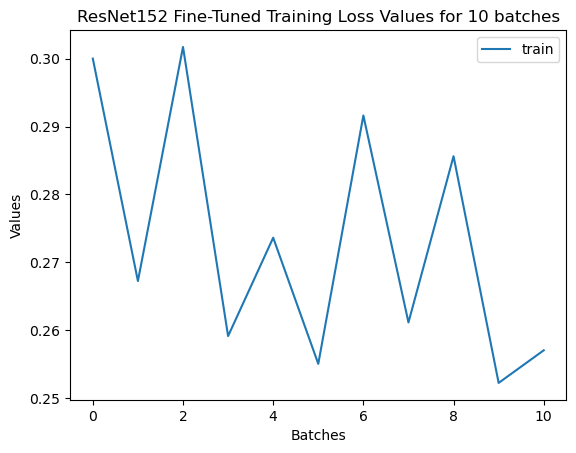

In [16]:
plt.plot(train_losses, label='train')
plt.title(f'ResNet152 Fine-Tuned Training Loss Values for {len(train_losses)-1} batches')
plt.ylabel('Values')
plt.xlabel('Batches')
plt.legend()
plt.show()

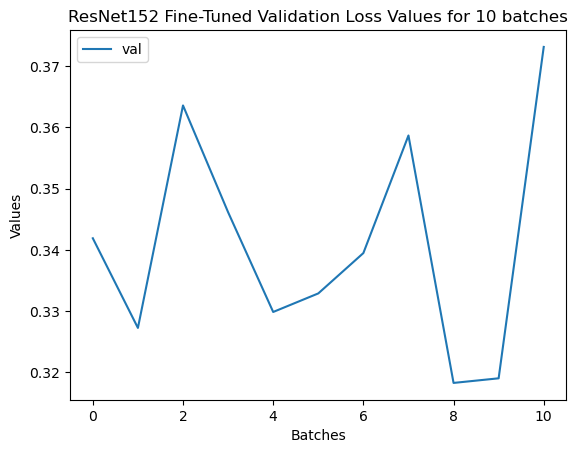

In [17]:
plt.plot(val_losses, label='val')
plt.title(f'ResNet152 Fine-Tuned Validation Loss Values for {len(val_losses)-1} batches')
plt.ylabel('Values')
plt.xlabel('Batches')
plt.legend()
plt.show()

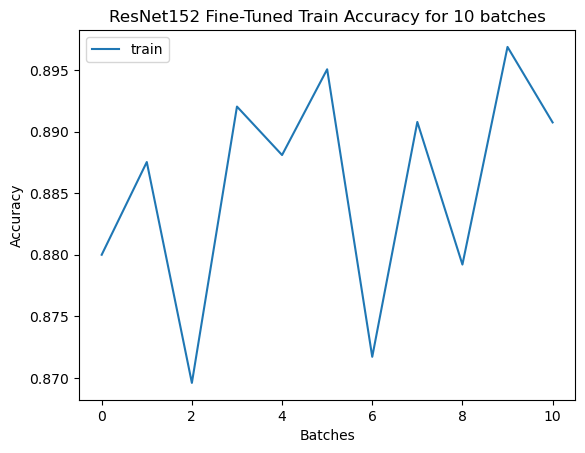

In [18]:
plt.plot(train_accuracy, label='train')
plt.title(f'ResNet152 Fine-Tuned Train Accuracy for {len(train_accuracy)-1} batches')
plt.ylabel('Accuracy')
plt.xlabel('Batches')
plt.legend()
plt.show()

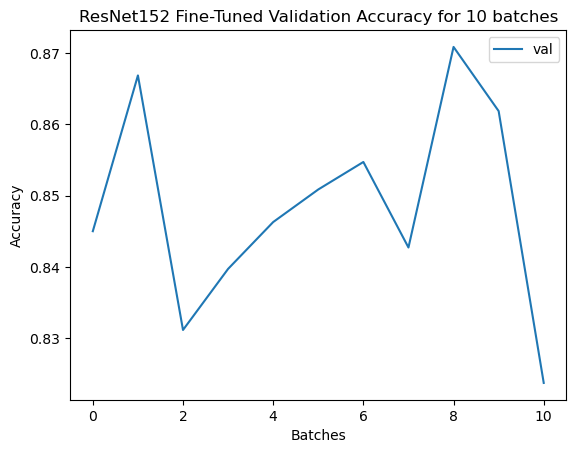

In [19]:
plt.plot(val_accuracy, label='val')
plt.title(f'ResNet152 Fine-Tuned Validation Accuracy for {len(val_accuracy)-1} batches')
plt.ylabel('Accuracy')
plt.xlabel('Batches')
plt.legend()
plt.show()

In [20]:
max(val_accuracy[1:])

0.8708571314811706

In [21]:
min(val_losses[1:])

0.318266561627388

In [39]:
test_loader = DataLoader(BevDataset(split='test'), shuffle=True, batch_size=batch_size)
test_accuracy = []
test_loss = []

@torch.no_grad
def evaluate():
    model.eval()
    for x, y_truth, _ in test_loader:
        x, y_truth = x.to(device), y_truth.to(device)

        y_hat = model(x)
        loss = criterion(y_hat, y_truth)
        test_loss.append(loss.item())

        accuracy = (y_hat.argmax(1) == y_truth).float().mean()
        test_accuracy.append(accuracy.item())

    avg_loss = sum(test_loss) / len(test_loss)
    avg_accuracy = sum(test_accuracy) / len(test_accuracy)
    print(f'test loss: {avg_loss:.4f} test accuracy: {avg_accuracy:.3f}')

evaluate()

test loss: 0.3053 test accuracy: 0.878


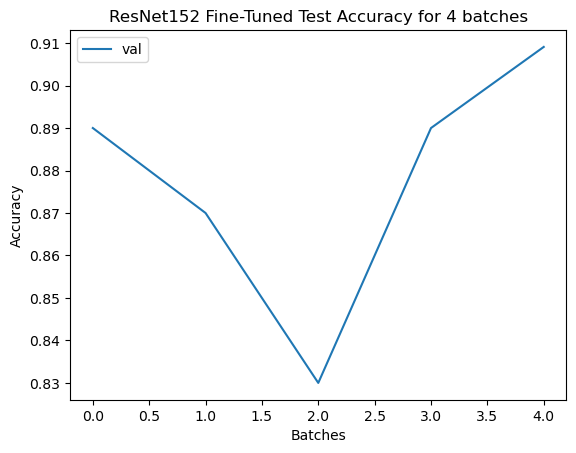

In [40]:
plt.plot(test_accuracy, label='val')
plt.title(f'ResNet152 Fine-Tuned Test Accuracy for {len(test_accuracy)-1} batches')
plt.ylabel('Accuracy')
plt.xlabel('Batches')
plt.legend()
plt.show()